In [32]:
import torch
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 299x299 for Inception V3
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Define dataset paths
train_dir = '/kaggle/input/skin-data/data/train'
val_dir = '/kaggle/input/skin-data/data/val'
test_dir = '/kaggle/input/skin-data/data/test'

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
diseases = os.listdir(train_dir)
# Get class names
classes = train_dataset.classes
num_classes = len(classes)
print(f"Classes: {classes}")


Classes: ['Nail_psoriasis', 'SJS-TEN', 'Vitiligo', 'acne', 'hyperpigmentation']


In [8]:
from torchvision import models
import torch.nn as nn

# Load the pre-trained Inception V3 model
model = models.inception_v3(pretrained=True, aux_logits=True)  # Enable auxiliary logits

# Modify the final fully connected layer for your number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [9]:
import torch.optim as optim

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            if isinstance(outputs, tuple):  # Handle auxiliary outputs
                outputs, aux_outputs = outputs
                main_loss = criterion(outputs, labels)
                aux_loss = criterion(aux_outputs, labels)
                loss = main_loss + 0.4 * aux_loss  # Combine losses with a weight
            else:
                loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple):  # Handle auxiliary outputs
                    outputs = outputs[0]  # Use only the main output
                loss = criterion(outputs, labels)

                # Track metrics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        # Update scheduler
        if scheduler:
            scheduler.step()

        # Print metrics
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    return model


In [11]:
num_epochs = 5
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)


Epoch 1/5
  Train Loss: 0.7155, Train Acc: 83.19%
  Val Loss: 0.2919, Val Acc: 89.75%
Epoch 2/5
  Train Loss: 0.3205, Train Acc: 92.02%
  Val Loss: 0.1382, Val Acc: 95.61%
Epoch 3/5
  Train Loss: 0.1956, Train Acc: 95.13%
  Val Loss: 0.3125, Val Acc: 90.17%
Epoch 4/5
  Train Loss: 0.1550, Train Acc: 96.30%
  Val Loss: 0.1420, Val Acc: 95.08%
Epoch 5/5
  Train Loss: 0.1336, Train Acc: 96.97%
  Val Loss: 0.1320, Val Acc: 95.71%


In [20]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
test_dir = "../input/skin-data/data/test"
test = ImageFolder(test_dir, transform=transform)
test_dl = DataLoader(test, batch_size, num_workers=2, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

In [25]:
test_images = sorted(os.listdir(test_dir + '/acne')) # since images in test folder are in alphabetical order
test_images

['150__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 '152__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 '172__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 '178__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 '195__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_0300149__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_0300151__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_0300166__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_0300176__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_0300179__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_100400148__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_100400176__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_100400189__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-100350_100300169_

Test Loss: 0.1154, Test Accuracy: 0.9740
Confusion Matrix:
[[249   3   1   0   0]
 [  1 315   1   0   0]
 [  0   3 188   0  10]
 [  0   4   0 111   0]
 [  0   1   1   0  68]]


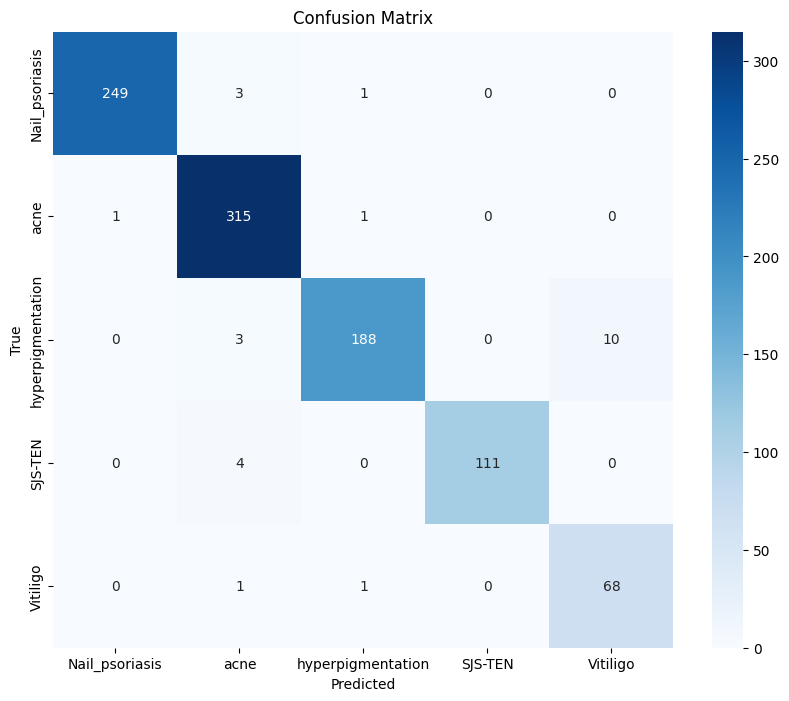

Classification Report:
                   precision    recall  f1-score   support

   Nail_psoriasis       1.00      0.98      0.99       253
             acne       0.97      0.99      0.98       317
hyperpigmentation       0.98      0.94      0.96       201
          SJS-TEN       1.00      0.97      0.98       115
         Vitiligo       0.87      0.97      0.92        70

         accuracy                           0.97       956
        macro avg       0.96      0.97      0.97       956
     weighted avg       0.98      0.97      0.97       956



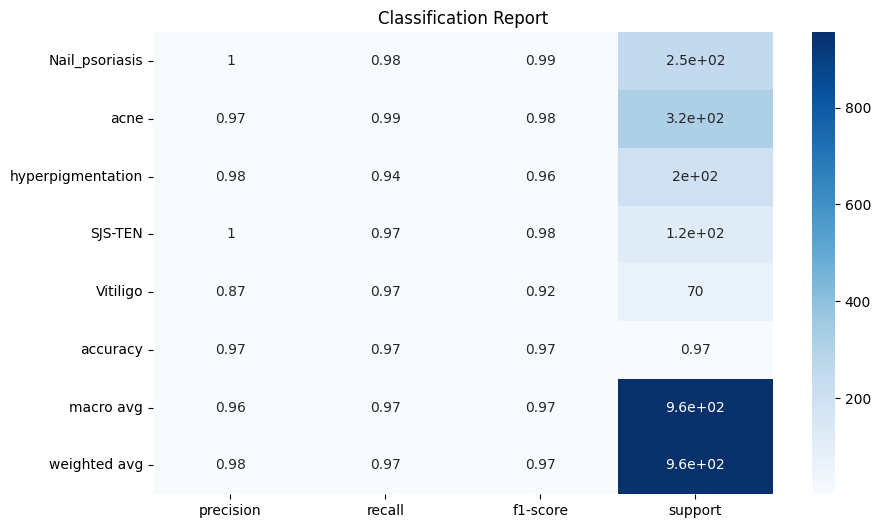

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Evaluate the model on the GPU
model.eval()
with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []

    total_loss = 0
    total_accuracy = 0

    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        test_outputs = model(images)
        test_loss = F.cross_entropy(test_outputs, labels)  # Calculate loss
        total_loss += test_loss.item()

        accuracy = (test_outputs.argmax(dim=1) == labels).float().mean()
        total_accuracy += accuracy.item()

        # Collect predictions and true labels for confusion matrix
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(test_outputs.argmax(dim=1).cpu().numpy())
    # Calculate average loss and accuracy
    avg_loss = total_loss / len(test_dl)
    avg_accuracy = total_accuracy / len(test_dl)

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_accuracy:.4f}')
    # Convert to numpy arrays for further analysis
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    # Confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=diseases, yticklabels=diseases)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification report
    class_report = classification_report(all_true_labels, all_predicted_labels, target_names=diseases)
    print("Classification Report:")
    print(class_report)

    # Plot classification report
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame.from_dict(classification_report(all_true_labels, all_predicted_labels, target_names=diseases, output_dict=True)).T, annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.show()

In [34]:
# saving to the kaggle working directory
PATH = './skin-disease-model.pth'  
torch.save(model.state_dict(), PATH)